In [1]:
import os, shutil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from PIL import Image
from keras.utils import plot_model
from IPython.display import Image 

# preprocessing
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# modelling
import keras
import tensorflow as tf
from keras import layers
from keras import models
from keras import utils
from keras import optimizers
from keras.models import Sequential
from keras.losses import binary_crossentropy, categorical_crossentropy
from keras.optimizers import SGD, Adam
from keras.applications.vgg19 import VGG19
from keras import losses
from keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
import math 

# callbacks
from keras.callbacks import History

from google.colab import drive
drive.mount('/content/gdrive')

Using TensorFlow backend.


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
IMAGE_PATH = "/content/gdrive/My Drive/Colab Notebooks/melanoma_classification/siim-isic-melanoma-classification/torch_jpeg/"

train_folder = os.path.join(IMAGE_PATH, 'train')
test_folder = os.path.join(IMAGE_PATH, 'test')


In [5]:
#train_benign = os.path.join(IMAGE_PATH + 'train' + '/', 'benign')
#test_benign = os.path.join(IMAGE_PATH + 'test' + '/', 'benign')
#files = os.listdir(train_benign)
#for f in files:
#  if np.random.rand(1) < .2:
#    shutil.move(train_benign + '/' + f, test_benign + '/' + f )

#train_malignant = os.path.join(IMAGE_PATH + 'train' + '/', 'malignant')
#test_malignant = os.path.join(IMAGE_PATH + 'test' + '/', 'malignant')
#files = os.listdir(train_malignant)
#for f in files:
#  if np.random.rand(1) < .2:
#    shutil.move(train_malignant + '/' + f, test_malignant + '/' + f )

In [4]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.3,
        rotation_range=30,
        horizontal_flip=True,
      #  vertical_flip=True,
        validation_split = 0.2)

# get all the data in the directory /train and reshape them
train_generator = train_datagen.flow_from_directory(
        train_folder, 
        target_size=(224, 224),  
        batch_size=4096,
        classes=['benign', 'malignant'])

# get all the data in the directory /train and reshape them
test_generator = train_datagen.flow_from_directory(
        test_folder, 
        target_size=(224, 224), 
        batch_size = 128,
        classes=['benign', 'malignant']
        ) 

# get all the data in the directory /val and reshape them
val_generator = train_datagen.flow_from_directory(
        train_folder,
        target_size=(224, 224), 
        batch_size= 128,
        # class_mode='binary',
        subset='validation',
        classes=['benign', 'malignant'])




Found 9692 images belonging to 2 classes.
Found 4135 images belonging to 2 classes.
Found 1937 images belonging to 2 classes.


In [6]:
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

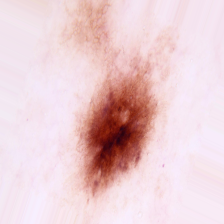

In [7]:
#@title Default title text

#preview training image
array_to_img(train_images[233])


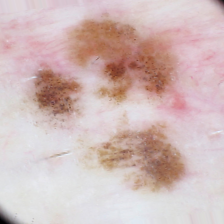

In [8]:
#preview training image
array_to_img(train_images[5])

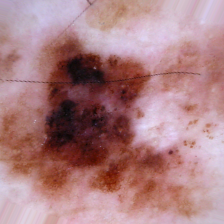

In [9]:
#preview training image
array_to_img(train_images[84])

In [10]:
# get shape of images in train and test

print(np.shape(train_images))
print(np.shape(train_labels))
print(np.shape(test_images))
print(np.shape(test_labels))
print(np.shape(val_images))
print(np.shape(val_labels))

(4096, 224, 224, 3)
(4096, 2)
(128, 224, 224, 3)
(128, 2)
(128, 224, 224, 3)
(128, 2)


In [11]:

# reshape images to contain dimensions into a single vector
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

(4096, 150528)
(128, 150528)
(128, 150528)


In [12]:
# reshape images to contain dimensions into a single vector
train_y = np.reshape(train_labels[:,0], (4096,1))
test_y = np.reshape(test_labels[:,0], (128,1))
val_y = np.reshape(val_labels[:,0], (128,1))

In [13]:
#preview label to identify class valujes
train_labels

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [14]:

#identify the categorical values of 0 and 1
train_generator.class_indices

{'benign': 0, 'malignant': 1}

In [15]:
train_labels_final = train_labels.T[[1]]
np.shape(train_labels_final)


(1, 4096)

In [16]:
test_labels_final = test_labels.T[[1]]
np.shape(test_labels_final)

(1, 128)

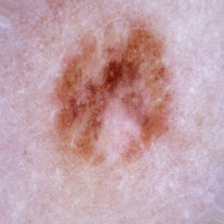

In [17]:
array_to_img(train_images[210])

In [18]:
train_labels_final[:,210]

array([0.], dtype=float32)

### Base CNN Model

In [19]:
np.random.seed(123)

# model = models.Sequential()
# model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
 
# model.add(layers.Flatten())
# model.add(layers.Dense(10, activation='softmax'))


base_model = models.Sequential()
base_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224, 224,  3)))
base_model.add(layers.MaxPooling2D((2, 2)))

base_model.add(layers.Conv2D(32, (4, 4), activation='relu'))
base_model.add(layers.MaxPooling2D((2, 2)))

base_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
base_model.add(layers.MaxPooling2D((2, 2)))

base_model.add(layers.Flatten())
base_model.add(layers.Dense(64, activation='relu'))
base_model.add(layers.Dense(1, activation='sigmoid'))

base_model.compile(loss='binary_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])
 
# model.compile(loss='sparse_categorical_crossentropy',
#               optimizer='sgd',
#               metrics=['accuracy'])

base_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 32)      16416     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 43264)            

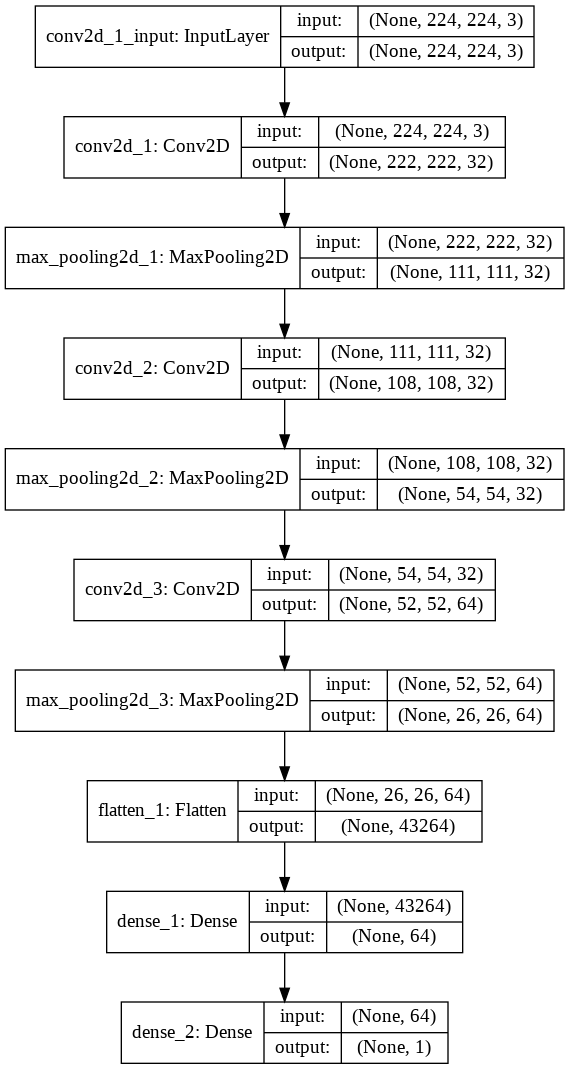

In [20]:
plot_model(base_model, show_shapes=True, show_layer_names=True)

In [21]:
history = base_model.fit(train_images,
          train_y,
          epochs=10,
          # batch_size=32,
          validation_data=(val_images, val_y))

Train on 4096 samples, validate on 128 samples
Epoch 1/10
4096/4096 [==============================] - 162s 40ms/step - loss: 0.6858 - accuracy: 0.5623 - val_loss: 0.6907 - val_accuracy: 0.5625
Epoch 2/10
4096/4096 [==============================] - 160s 39ms/step - loss: 0.6833 - accuracy: 0.5625 - val_loss: 0.6830 - val_accuracy: 0.5625
Epoch 3/10
4096/4096 [==============================] - 161s 39ms/step - loss: 0.6806 - accuracy: 0.5623 - val_loss: 0.6724 - val_accuracy: 0.5625
Epoch 4/10
4096/4096 [==============================] - 160s 39ms/step - loss: 0.6799 - accuracy: 0.5681 - val_loss: 0.6745 - val_accuracy: 0.5703
Epoch 5/10
4096/4096 [==============================] - 160s 39ms/step - loss: 0.6779 - accuracy: 0.5688 - val_loss: 0.6712 - val_accuracy: 0.7656
Epoch 6/10
4096/4096 [==============================] - 160s 39ms/step - loss: 0.6780 - accuracy: 0.5732 - val_loss: 0.6761 - val_accuracy: 0.5938
Epoch 7/10
4096/4096 [==============================] - 160s 39ms/step 

In [22]:
results_train = base_model.evaluate(train_images, train_y)

4096/4096 [==============================] - 35s 9ms/step


In [23]:
results_test = base_model.evaluate(test_images, test_y)

128/128 [==============================] - 1s 9ms/step


In [24]:
results_train

[0.6538171535357833, 0.619384765625]

In [25]:
results_test

[0.604598194360733, 0.734375]

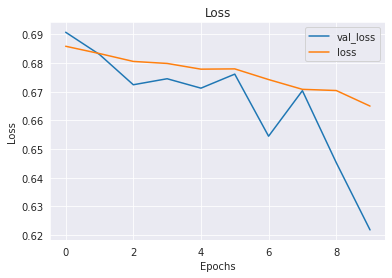

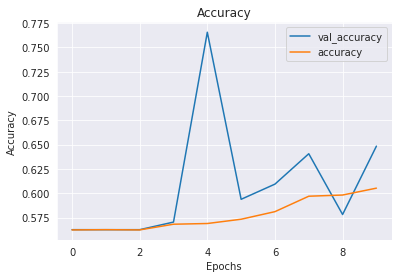

In [26]:
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

visualize_training_results(history)

### Model 2

In [27]:
np.random.seed(123)

base2_model = models.Sequential()
base2_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224, 224,  3)))
base2_model.add(layers.MaxPooling2D((2, 2)))

base2_model.add(layers.Conv2D(32, (4, 4), activation='relu'))
base2_model.add(layers.MaxPooling2D((2, 2)))

base2_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
base2_model.add(layers.MaxPooling2D((2, 2)))
base2_model.add(layers.Flatten())
base2_model.add(layers.Dense(64, activation='relu'))
base2_model.add(layers.Dense(1, activation='sigmoid'))

base2_model.compile(loss='binary_crossentropy',
              optimizer='sgd',
              metrics=['accuracy']) 

base2_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 108, 108, 32)      16416     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 43264)            

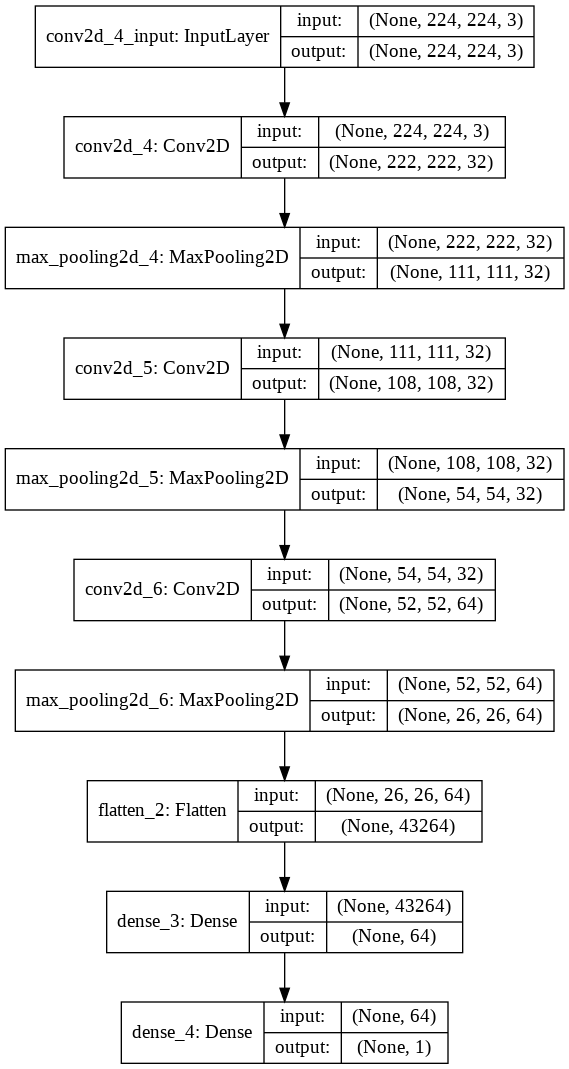

In [28]:
plot_model(base2_model, show_shapes=True, show_layer_names=True)

In [29]:
history = base2_model.fit(train_images,
          train_y,
          epochs=40,
          batch_size=128,
          validation_data=(val_images, val_y))

Train on 4096 samples, validate on 128 samples
Epoch 1/40
4096/4096 [==============================] - 160s 39ms/step - loss: 0.6863 - accuracy: 0.5623 - val_loss: 0.6888 - val_accuracy: 0.5625
Epoch 2/40
4096/4096 [==============================] - 157s 38ms/step - loss: 0.6851 - accuracy: 0.5623 - val_loss: 0.6878 - val_accuracy: 0.5625
Epoch 3/40
4096/4096 [==============================] - 158s 38ms/step - loss: 0.6847 - accuracy: 0.5623 - val_loss: 0.6853 - val_accuracy: 0.5625
Epoch 4/40
4096/4096 [==============================] - 157s 38ms/step - loss: 0.6832 - accuracy: 0.5632 - val_loss: 0.6838 - val_accuracy: 0.5625
Epoch 5/40
4096/4096 [==============================] - 157s 38ms/step - loss: 0.6822 - accuracy: 0.5630 - val_loss: 0.6858 - val_accuracy: 0.5938
Epoch 6/40
4096/4096 [==============================] - 157s 38ms/step - loss: 0.6827 - accuracy: 0.5591 - val_loss: 0.6803 - val_accuracy: 0.5625
Epoch 7/40
4096/4096 [==============================] - 157s 38ms/step 

In [30]:
results_train = base2_model.evaluate(train_images, train_y)

4096/4096 [==============================] - 38s 9ms/step


In [31]:
results_test = base2_model.evaluate(test_images, test_y)

128/128 [==============================] - 1s 9ms/step


In [32]:
results_train

[0.649362369440496, 0.639404296875]

In [33]:
results_test

[0.5992462635040283, 0.7578125]

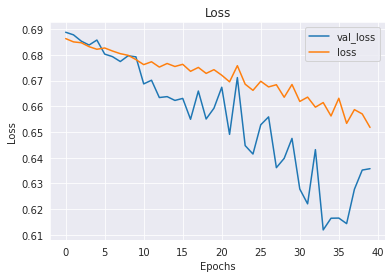

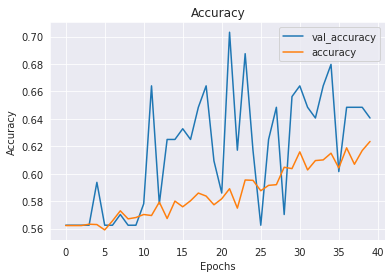

In [34]:
visualize_training_results(history)



In [43]:
base_model.save('keras_model.h5')

In [46]:
base2_model.save('keras2_model.h5')